# Letal COVID-19 snRNA Analysis
# Section 5: Integration
Author: MikiasHWT  
Start: December 9, 2024  

In [13]:
from datetime import datetime
current_date = datetime.now().strftime("%B %d, %Y")
print(f"Updated: {current_date}")

Updated: December 29, 2024


# Background

Despite our best efforts to clean our data in the previous sections, we still have various factors left that are the cause of non relevant differences between our samples. Before we can annotate our samples or apply any analysis (or after we apply a annotation), we need to integrate our samples into a single data object while controlling for any variables that act as confounding factors. These confounding variables can be differences in sample origins, handling and sequencing depths to name a few. As always, various methods exist as well as a respectable number of benchmarking studies. The methodogies vary in complexity, especially in recent years and the results also tend to vary and require a careful consideration of the specific questions at hand. 

With this dataset we have lung tissue from 19 patients (12M, 7F, mediage age 72) who died of COVID-19 and biopsy samples from 7 pre-pandemic controls (4M, 3F, median age 70). The median age of the patient samples, as well as the sex distribution appear to be somewhat controlled. Patient healthy histories are provided in supplemental data and will be considered in future itterations of this workbook. But ultimately the differences that concern me are the differences between the Covid samples and the control samples, such as time of collection and length and method of storage. Some differences will be true biological differences due to viral infection and will be critical to the analysis, while other differences will have been caused technical artifacts of handling and data collection. 

We will initially attempt to integrate the samples without any consideration of variablity. Using UMAP plots as our primary method of validation, we will note that our clusters for by cell type as well as by experimental condition (COVID vs Control). This is an result of ignoring any influence of batch effect between the samples. Instead we want UMAP plots clustered by cell type alone such that any given cell types from both COVID and Control samples will intermingle within one distinct cluster instead of forming two adjecent clusters. 


## Objective

- Integrate 27 sequencing samples into a single anndata object
    - On local computer or...
    - Through an AWS EC2 instance to unload the computational burden
- label each cell/observation with its sample of origin
- Optimize pipeline & code for performance
- Confirm proper integration
- Check for batch effects

# Prep Workspace

## Import Libraries

In [14]:
# Default 
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
import scanpy as sc  # Single-cell data analysis
import os  # Operating system interface

import anndata
from scipy.stats import median_abs_deviation  # Robust statistic for dispersion
from scipy.sparse import csr_matrix # Handle sparce matrix
from IPython.display import display, clear_output

# Memory
import cProfile
import psutil
import sys
import pdb # debugger


## Directories

In [15]:
# Define directories 
datDir = os.path.abspath("data")
outDir = os.path.abspath("output")

# Integrate

We begin by defining a function to integrate our 27 patient samples into a single Anndata object. (We will also resuse our outlier deteciton funciton from the Quality Control section of our workflow)

We apply the following steps during integration:
- Read datafile
- Annotate sample name
- Calculate QC metrics
- Filter our genes expressed in less than 3 cells
- Detect and remove outliers
    - Outliers: Above 5 Median Absolute Deviations (MAD) of `total gene counts` and `unique gene counts`
- Combine each sample into a single object

## Define Functions

In [16]:
# Create MAD function
def is_outlier(adata, qcmetric: str, madunits: int):
    """
    Identified outlier points using the Mean Absolute Deviation function from scipy

    Args:
        adata (_type_): Anndata object with RNA data
        qcmetric (str): QC metric to use for outlier detection
        madunits (int): Value of MAD units to use for the QC metric

    Returns:
        _type_: Boolean value identifying outliers
    """
    M = adata.obs[qcmetric]
    outlier = (M < np.median(M) - madunits * median_abs_deviation(M)) | (M > np.median(M) + madunits * median_abs_deviation(M))
    return outlier

In [17]:
import os
from time import sleep
from tqdm import tqdm
import scanpy as sc
import anndata
from scipy.sparse import csr_matrix
from IPython.display import clear_output
from memory_profiler import memory_usage
import gc # Memory clearing

def process_and_integrate(data_dir):
    """
    Processes and integrates single-cell RNA sequencing data from `.csv.gz` files.
    """
    adata_list = []
    files = [file for file in os.listdir(data_dir) if file.endswith('.csv.gz')]
    total_samples = len(files)

    for i, file in enumerate(tqdm(files, desc="Processing Files"), start=1):
        file_path = os.path.join(data_dir, file)
        try:
            # if i % 5 == 0 or i == total_samples:
            # mem_usage = memory_usage(-1, interval=1, timeout=1)
            # print(f"Memory usage at file {i}: {mem_usage} MB")

            sample_name = file.split("_")[1]
            mem_usage = memory_usage(-1, interval=1, timeout=1)
            print(f"Current memory usage: {mem_usage} MB")
            print(f"Loading {sample_name}. ({i} of {total_samples})")
                              
            adata = sc.read_csv(file_path).T  # Load and transpose data
            sc.pp.subsample(adata, fraction=0.1, random_state=42) # Subsample 10% cells (Return to this to check for bias)
            adata.obs["Sample"] = sample_name
            adata.obs["COVID"] = "cov" in sample_name.lower()

            # Print dataset info
            print(f"{adata.X.shape[0]} cells, {adata.X.shape[1]} genes for {sample_name}")
            
            # Quick trim
            sc.pp.filter_genes(adata, min_cells=3, inplace=True)

            adata_list.append(adata) # Append
            clear_output(wait=True)

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue
    
    # Memory Update
    mem_usage = memory_usage(-1, interval=1, timeout=1)
    print(f"Current memory usage: {mem_usage} MB")
    print("Combining Samples...")

    # Concatenate all AnnData objects
    combined_adata = anndata.concat(
        adata_list,
        join="inner",  # retain only common variables
        merge="same",
        label="Sample",
        keys=[ad.obs["Sample"].iloc[0] for ad in adata_list]
    )

    # Delete adata_list
    del adata_list
    gc.collect()
    clear_output(wait=True)
    mem_usage = memory_usage(-1, interval=1, timeout=1)
    print(f"Current memory usage: {mem_usage} MB")
    print(f"Object shape: {combined_adata.X.shape}")
    print("Starting workflow...")

    # Annotate genes
    combined_adata.var["mt"] = combined_adata.var_names.str.startswith("MT-")
    combined_adata.var["ribo"] = combined_adata.var_names.str.startswith(("RPS", "RPL"))
    combined_adata.var["hb"] = combined_adata.var_names.str.contains("^HB(?!P)", regex=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        combined_adata,
        qc_vars=["mt", "ribo", "hb"],
        inplace=True,
        percent_top=[20],
        log1p=True
    )

    # Filter genes and cells
    combined_adata.obs["outlier"] = (
        is_outlier(combined_adata, "log1p_total_counts", 5) |
        is_outlier(combined_adata, "log1p_n_genes_by_counts", 5)
    )
    combined_adata = combined_adata[~combined_adata.obs["outlier"]]

    print(f"Final object:\n{combined_adata}")
    print("Workflow completed successfully!")
        
    mem_usage = memory_usage(-1, interval=1, timeout=1)
    print(f"Current memory usage: {mem_usage} MB")
    
    return combined_adata


## Integrate

In [20]:
data_files = os.listdir(datDir)
data_files

['adata_C51ctr.h5ad',
 'C51ctr_Clustered.h5ad',
 'C51ctr_HVG.h5ad',
 'C51ctr_Normalized.h5ad',
 'C51ctr_QC.h5ad',
 'COVID19_Integrated.h5ad',
 'COVID19_Integrated_Control_Set.h5ad',
 'COVID19_Integrated_Draft.h5ad',
 'COVID19_QCd_Pooled_Samples.h5ad',
 'GSE171524_RAW',
 'GSE171524_RAW.tar',
 'integration.ipynb',
 'ref',
 'scRNA_Lethal_COVID19_Analysis.ipynb',
 'scRNA_Lethal_COVID19_Analysis_requirements.txt',
 'Suplementary2_Cell_Type_Assignments.xlsx',
 'Supplementary4_Gene_Signatures.xlsx',
 'Supplementary_Table1_Clinical_Information.xlsx',
 'Uncompressed_adata_C51ctr.h5ad']

In [24]:
# This step will take some time
control_set_adata = process_and_integrate("data\\GSE171524_RAW")

Current memory usage: [850.33984375] MB
Object shape: (11621, 6155)
Starting workflow...
Final object:
View of AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
Workflow completed successfully!
Current memory usage: [850.42578125] MB


In [25]:
# Save object for future use
control_set_adata.write("data/COVID19_Integrated_Control_Set_Raw.h5ad")

In [27]:
# Save counts data as layer
control_set_adata.layers["counts"] = csr_matrix(control_set_adata.X).copy()

C:\Users\Owner\AppData\Local\Temp\ipykernel_2204\278838603.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  control_set_adata.layers["counts"] = csr_matrix(control_set_adata.X).copy()


In [28]:
# Inspect object
control_set_adata

AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

# Dimensionality Reduce & Cluster

In [33]:
sc.pp.pca(control_set_adata)

# sc.pp.pca(control_set_adata, svd_solver="arpack", mask_var="highly_variable")

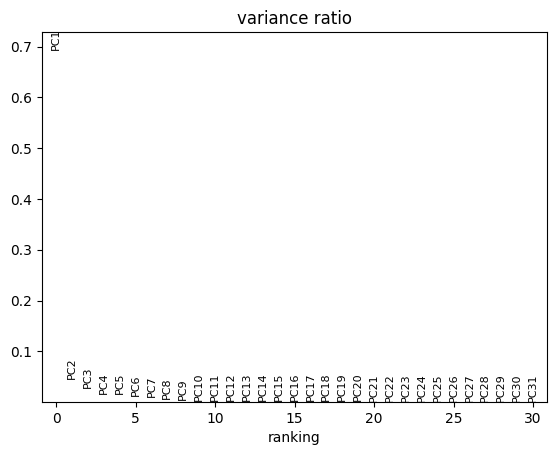

In [34]:
sc.pl.pca_variance_ratio(control_set_adata)


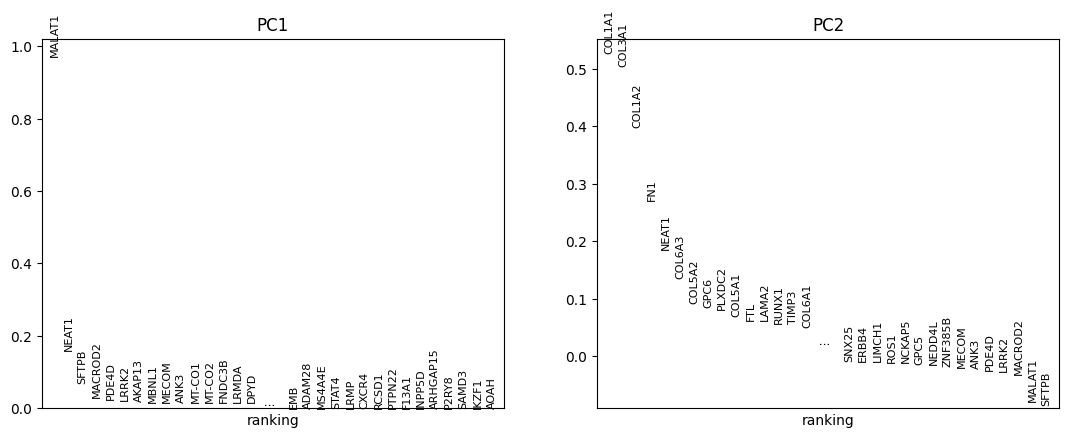

In [35]:
sc.pl.pca_loadings(control_set_adata, components = '1,2');



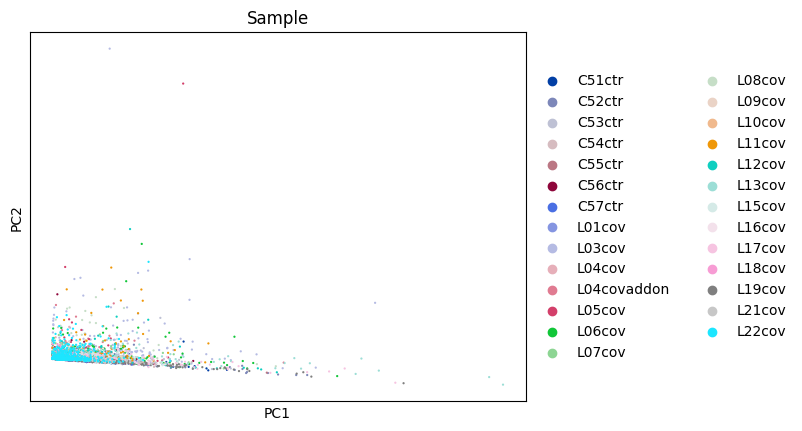

In [36]:
# Visualize
sc.pl.pca_scatter(control_set_adata, color="Sample")


In [37]:
# Apply tSNE

sc.tl.tsne(control_set_adata, use_rep="X_pca")
control_set_adata



AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'

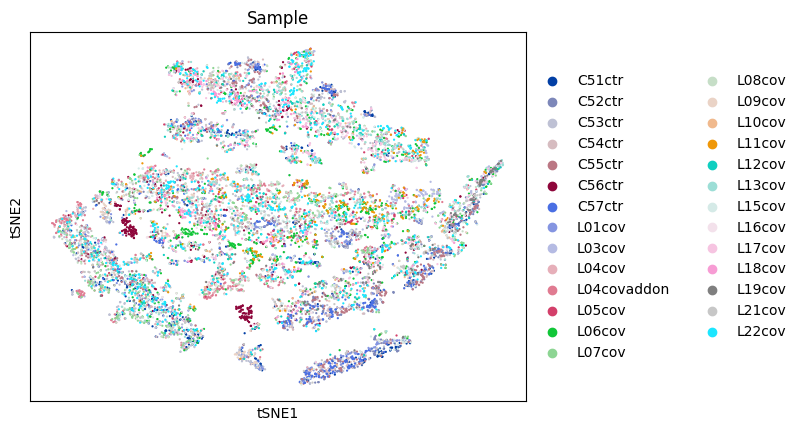

In [38]:
# Visualize tSNE
sc.pl.tsne(control_set_adata, color="Sample")


In [39]:
# UMAP
sc.pp.neighbors(control_set_adata)
sc.tl.umap(control_set_adata)
control_set_adata



c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

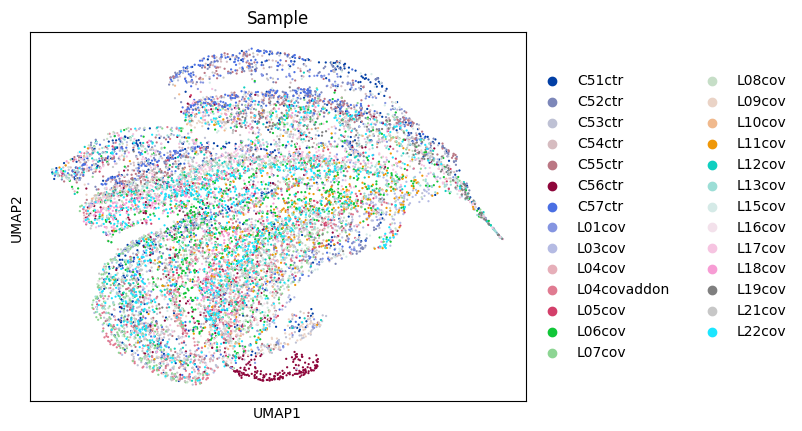

In [40]:
# Plot
sc.pl.umap(control_set_adata, color="Sample")


In [41]:
control_set_adata

AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

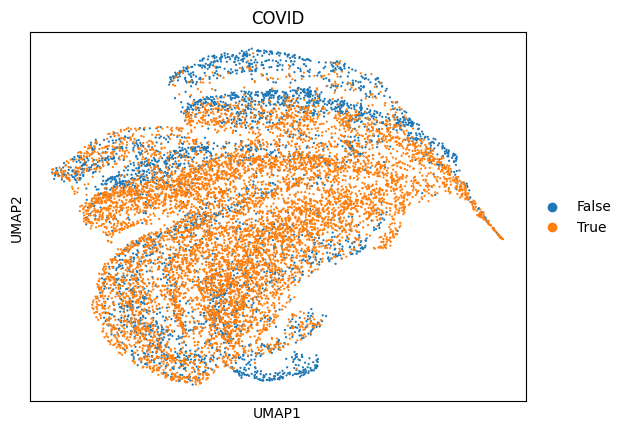

In [42]:
# Plot
sc.pl.umap(control_set_adata, color="COVID")


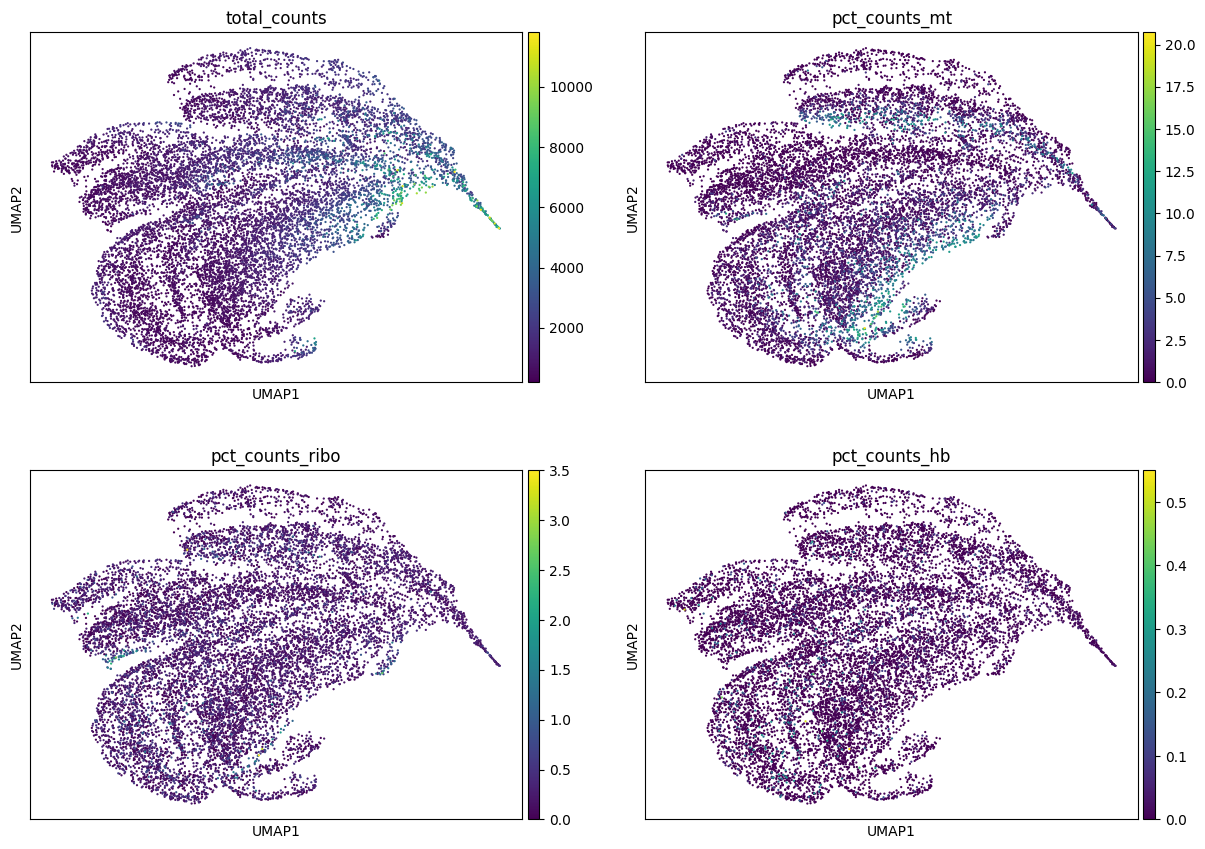

In [43]:
# Inspect quality control 
sc.pl.umap(
    control_set_adata,
    color=["total_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    ncols=2
)


KeyError: 'Could not find key CD3E in .var_names or .obs.columns.'

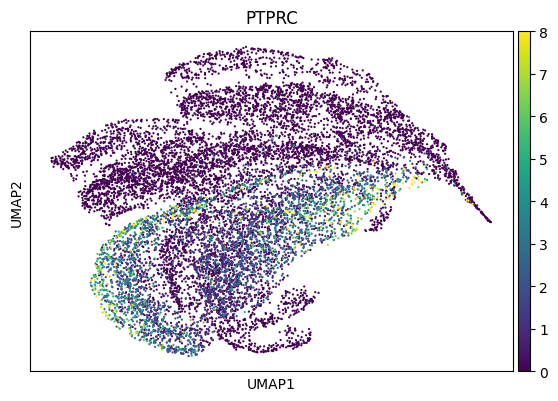

In [44]:
# Common markers List to compare feature selection methods
markers = ["PTPRC", "CD3E", "CD4", "HLA-E", "ITGAX", "ITGAM", "CD14", "VCAN", "FOXJ1", "SFTPC", "MUC1", "EPCAM", "CD69", "IGHM"] #"CCR2", "CD19"

# Color by chosen markers
sc.pl.umap(control_set_adata, color=markers, ncols=3, vmin=0, vmax="p99")


In [45]:
import scvi
import scib

c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
c:

In [46]:
label_key = "cell_type"
batch_key = "COVID"

In [47]:
control_set_adata

AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [48]:
control_set_adata.X = control_set_adata.layers["counts"].copy()
sc.pp.normalize_total(control_set_adata)
sc.pp.log1p(control_set_adata)
control_set_adata.layers["logcounts"] = control_set_adata.X.copy()
control_set_adata

AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [49]:
control_set_adata_backup = control_set_adata

In [50]:
control_set_adata.obs["COVID"] = control_set_adata.obs["COVID"].astype("category")
control_set_adata

AnnData object with n_obs × n_vars = 11608 × 6155
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [51]:
sc.pp.highly_variable_genes(
    control_set_adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)
control_set_adata
control_set_adata.var

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
UBE2J2,False,False,False,680,0.065055,0.063026,94.148524,756.0,6.629363,False,0.028146,0.668554,-0.461448,0,False
ACAP3,False,False,False,428,0.038809,0.038075,96.317012,451.0,6.113682,False,0.018005,0.678163,-0.004098,0,False
INTS11,False,False,False,457,0.041477,0.040640,96.067464,482.0,6.180017,True,0.021175,0.710975,0.906304,2,True
CCNL2,False,False,False,1789,0.183117,0.168152,84.605456,2128.0,7.663408,False,0.089423,0.655029,-0.742895,0,False
MRPL20,False,False,False,392,0.037260,0.036583,96.626796,433.0,6.073044,False,0.015950,0.691517,0.041901,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,True,False,False,3731,1.820411,1.036883,67.894329,21155.0,9.959679,True,0.376973,1.200185,5.227195,2,True
MT-ND5,True,False,False,2588,0.612942,0.478060,77.729972,7123.0,8.871224,True,0.184443,0.917756,3.141299,2,True
MT-ND6,True,False,False,2728,0.583427,0.459591,76.525256,6780.0,8.821879,True,0.189340,0.904763,2.962381,2,True
MT-CYB,True,False,False,2902,0.892608,0.637956,75.027967,10373.0,9.247058,True,0.238646,1.007807,3.298252,2,True


highly_variable_nbatches
0    3591
2    1436
1    1128
Name: count, dtype: int64

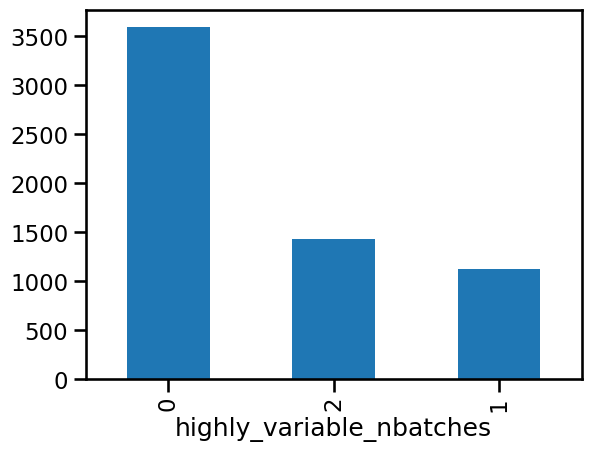

In [52]:
n_batches = control_set_adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [53]:
adata_hvg = control_set_adata[:, control_set_adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 11608 × 2000
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [54]:
adata_scvi = adata_hvg.copy()

In [55]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 11608 × 2000
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [56]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [57]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.1.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'COVID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 11608 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['COVID'] │   False    │          0          │
│                    │    True    │          1          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [58]:
max_epochs_scvi = np.min([round((20000 / control_set_adata.n_obs) * 400), 400])
max_epochs_scvi

400

In [59]:
# Long Step
model_scvi.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Owner\Documents\GitHub\scRNA_Lethal_Covid19_Analysis\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [38:03<00:00,  5.31s/it, v_num=1, train_loss_step=730, train_loss_epoch=726]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [38:03<00:00,  5.71s/it, v_num=1, train_loss_step=730, train_loss_epoch=726]


In [60]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [61]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 11608 × 2000
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', '_scvi_batch', '_scvi_labels'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

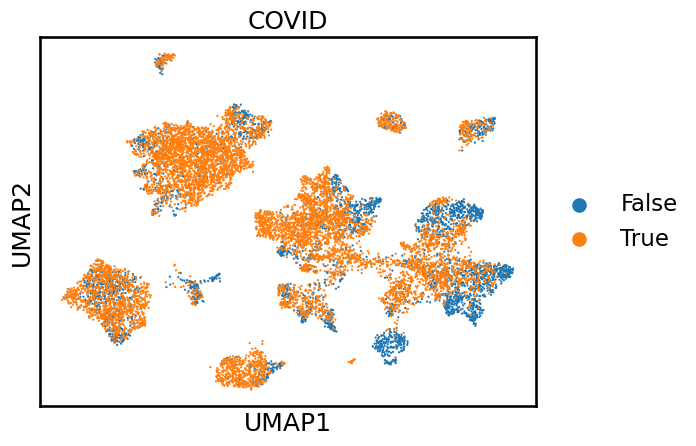

In [62]:
sc.pl.umap(adata_scvi, color=batch_key, wspace=1)

In [63]:

# Call Leiden algoritm with various resolutions 
for res in [0.02, 0.5, 1.0, 2.0]:
    sc.tl.leiden(
        adata_scvi, key_added=f"leiden_res_{res:4.2f}", resolution=res) # flavor="igraph", n_iterations=2)
    
adata_scvi



C:\Users\Owner\AppData\Local\Temp\ipykernel_2204\2654699215.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


AnnData object with n_obs × n_vars = 11608 × 2000
    obs: 'Sample', 'COVID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', '_scvi_batch', '_scvi_labels', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'Sample_colors', 'tsne', 'neighbors', 'umap', 'COVID_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_1.00', 'leiden_res_2.00'
    obsm: 'X_pca', 'X_ts

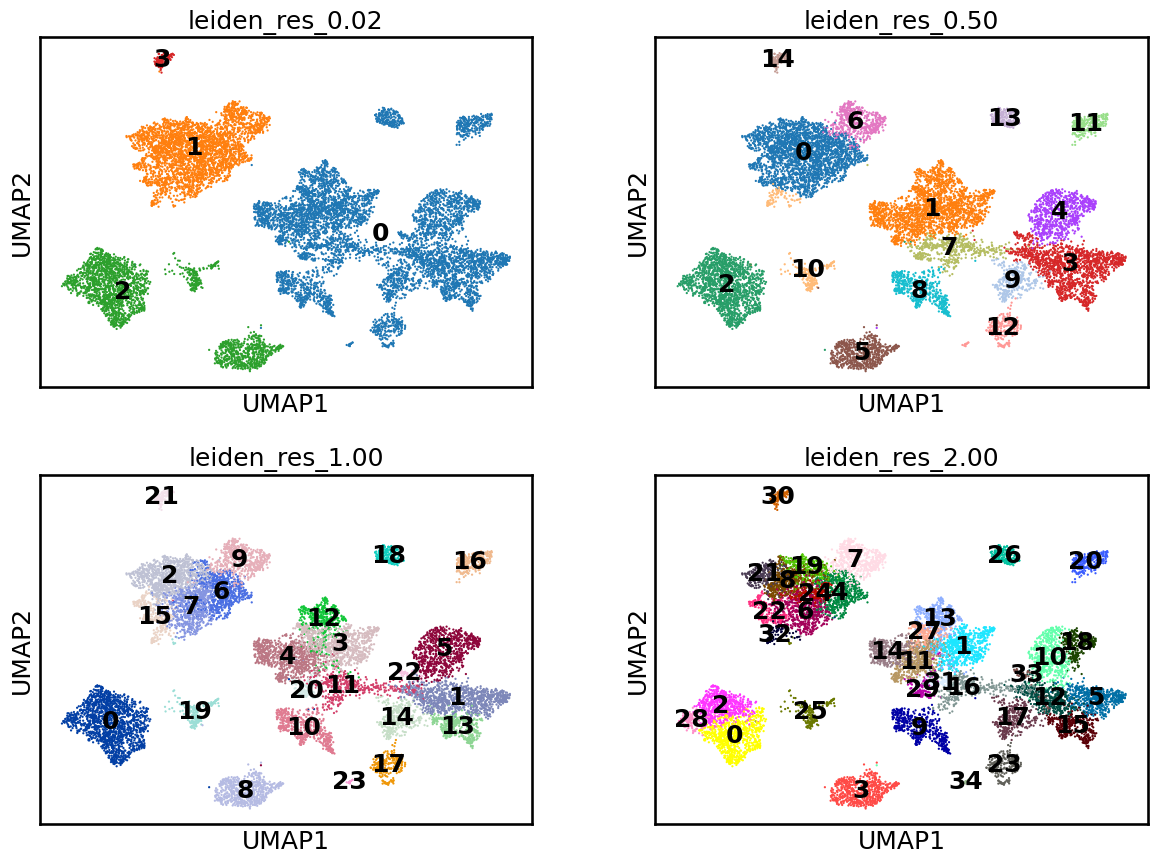

In [64]:
# Visualize outputs
sc.pl.umap(
    adata_scvi,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    ncols=2
)



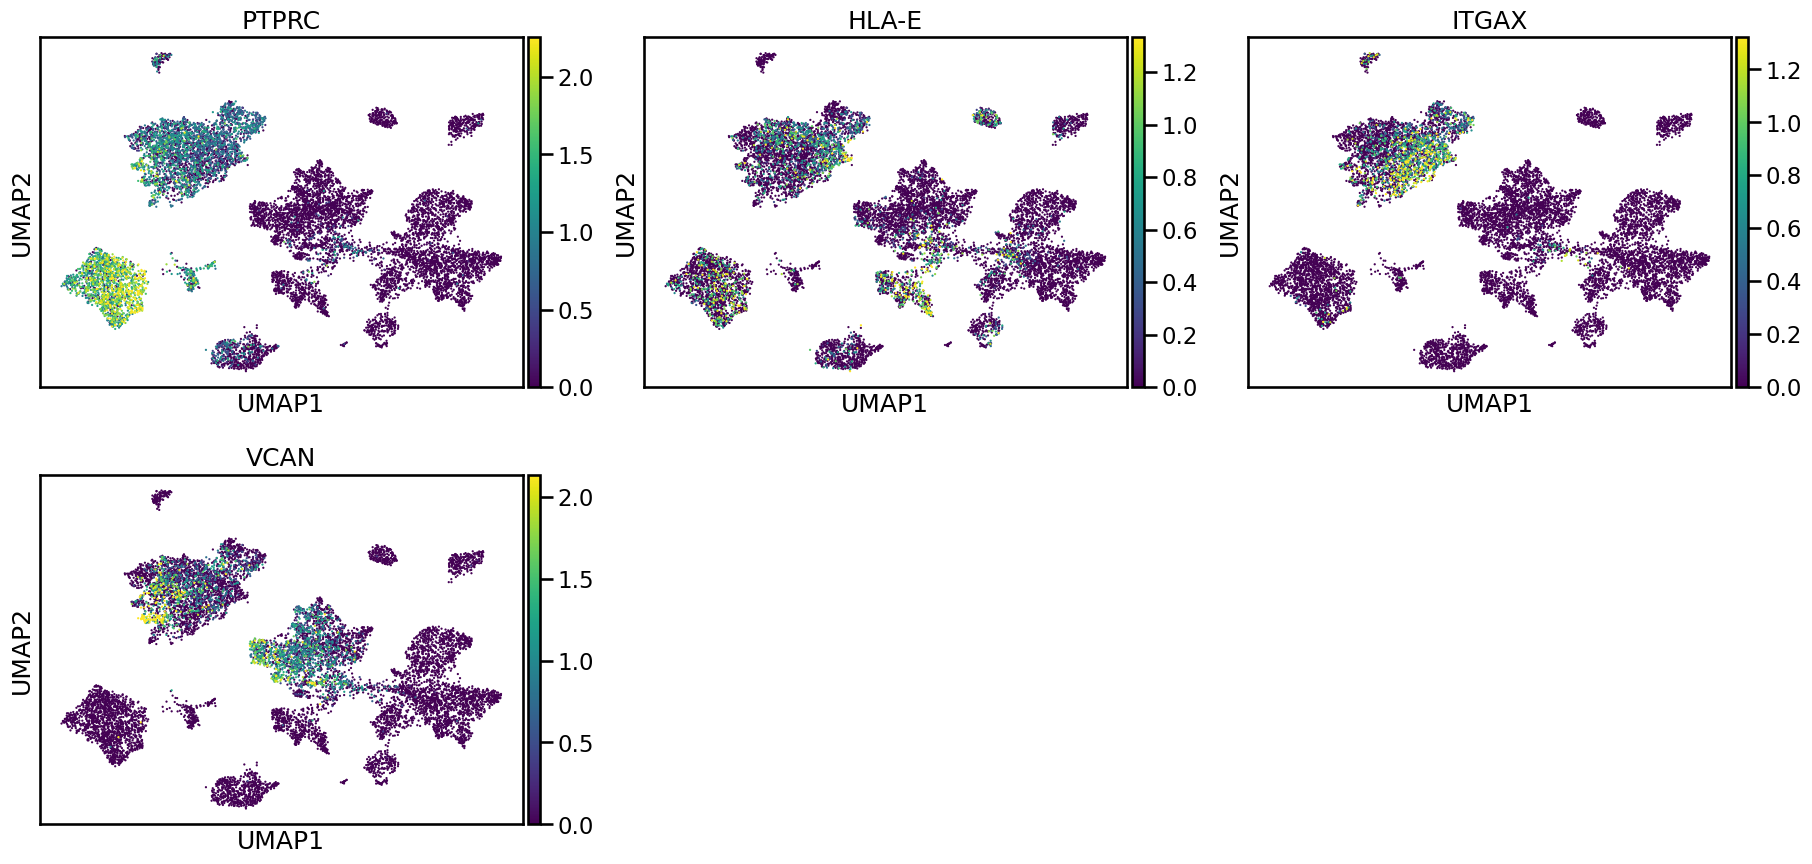

In [72]:
# Common markers List to compare feature selection methods
markers = ["PTPRC", "HLA-E", "ITGAX", "VCAN"] #"CD69", "SFTPC", "CD3E", "CCR2", "CD19", "CD4", "ITGAM","VCAN", "CD14", "FOXJ1","MUC1","EPCAM", "IGHM"

# Color by chosen markers
sc.pl.umap(adata_scvi, color=markers, ncols=3, vmin=0, vmax="p99")


In [66]:
adata_scvi.write("data/COVID19_Integrated_Control_Set.h5ad")

# Save Object

In [ ]:
# combined_adata

In [63]:
# Save object
# combined_adata.write("data/COVID19_Integrated_Draft1.h5ad")

# End Session

In [ ]:
import session_info
session_info.show()